In [1]:
import os
import sys
import importlib

os.environ["JAX_ENABLE_X64"] = "true"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['ENABLE_PJRT_COMPATIBILITY'] = 'true'
os.environ["JAX_PLATFORMS"] = "cpu"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.special import erfc

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font_axis_label = 16

import src
importlib.import_module(f'src')
for module in dir(src):
    if '__' not in module:
        print(module)
        importlib.import_module(f'src.{module}')
        importlib.reload(sys.modules[f'src.{module}'])

In [3]:
# Should be generate from the notebook `experiments_for_figure3.ipynb`

data = np.load("./results/combined_results_structured_svr_jax_all.npz", allow_pickle=True)

In [4]:
exp_params = data['exp_params'].tolist()
combined_exp_results = data['combined_exp_results'].tolist()
combined_th_results = data['combined_th_results'].tolist()
print(combined_exp_results.keys())

num_classes = exp_params['num_classes']
centroid_seed = exp_params['centroid_seed']

alpha_list = exp_params['alpha_list']
alpha_list_th = exp_params['alpha_list_th']
epsilon_list = exp_params['epsilon_list']
noise_list = exp_params['noise_list']
corr_list = exp_params['corr_list']

grid_size = exp_params['grid_size']
num_trials = exp_params['num_trials']

fn_list = exp_params['fn_list'][:1]

dict_keys(['1000_50_1e-14', '1000_50_0.01', '1000_100_1e-14', '1000_100_0.01', '5000_50_1e-14', '5000_50_0.01', '5000_100_1e-14', '5000_100_0.01', '5000_200_1e-10', '5000_400_1e-10', '5000_600_1e-10', '10000_200_1e-10', '10000_400_1e-10', '10000_600_1e-10'])


In [5]:
P, N, lamb = 10000, 600, 1e-10

all_results_exp = combined_exp_results[f'{P}_{N}_{lamb}']
all_results_th = combined_th_results[f'{P}_{N}_{lamb}']

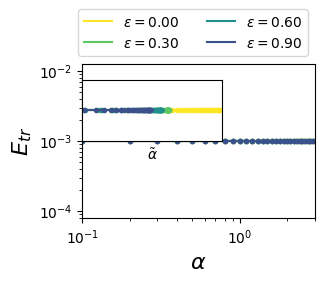

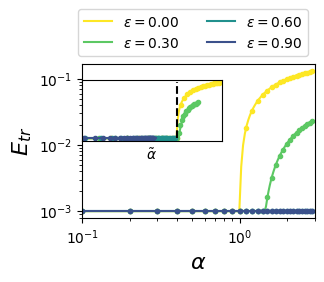

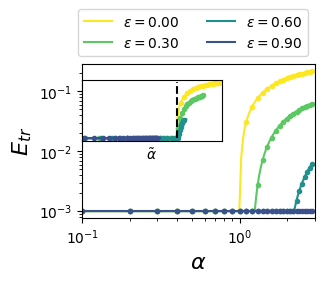

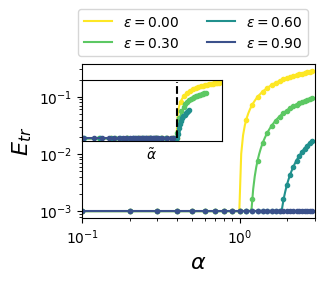

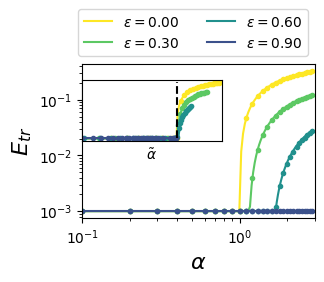

In [6]:
assert len(fn_list) > 0

noise_idx = -1
skip_idx = 1

eps_list = epsilon_list[::skip_idx]

for j, corr in enumerate(corr_list):

    fig, axs = plt.subplots(1, len(fn_list), figsize=(3*len(fn_list), 2))
    if len(fn_list) == 1:
        axs = [axs]
        
    ins_axs = [ax.inset_axes([0, 0.5, .6, .4]) for ax in axs]

    cmap_colors = [plt.cm.viridis_r(i) for i in np.linspace(0, 1, len(epsilon_list))]
    cmap_colors_alt = cmap_colors

    for n, fn in enumerate(fn_list):
        
        th_res = {key: all_results_th[key][j,noise_idx][::skip_idx] for key in ['C', 'Q', 'Chat', 'Qhat', 'Etr', 'alpha', 'alpha_eff', 'f']}
        th_res['Etr'] = th_res['Etr'] / (1+noise_list[noise_idx]**2*(1-corr))**2
        th_res = {key: np.clip(val, 1e-3, 1e2) for key, val in th_res.items()}
        alpha_th = th_res['alpha']
        alpha_eff_th = th_res['alpha_eff']
        
        exp_res = {key: all_results_exp[key][j,noise_idx][::skip_idx] for key in [f'gen_err_{fn}', f'tr_err_{fn}', f'eff_ratio_{fn}', f'eff_ratio2_{fn}']}
        exp_res = {key: np.clip(val, 1e-3, 1e2) for key, val in exp_res.items()}
        exp_res['alpha_exp'] = np.tile(alpha_list, (len(eps_list),1))
        exp_res['alpha_eff_exp'] = exp_res['alpha_exp'] * erfc(eps_list[:,None] / np.sqrt(2*exp_res[f'gen_err_{fn}']))
        exp_res['eff_ratio'] = exp_res[f'eff_ratio_{fn}']
        exp_res['eff_ratio2'] = exp_res[f'eff_ratio2_{fn}']
        exp_res = {key: np.clip(val, 1e-5, 1e2) for key, val in exp_res.items()}
        
        gen_err_svr = exp_res[f'gen_err_{fn}']
        tr_err_svr = exp_res[f'tr_err_{fn}']
        alpha_exp = exp_res['alpha_exp']
        alpha_eff_exp = exp_res[f'alpha_eff_exp']
        alpha_eff_exp2 = alpha_exp*exp_res['eff_ratio']
        alpha_eff_exp3 = alpha_exp*exp_res['eff_ratio2']
        
        ylims = [np.min(th_res['C']), np.min([1.5, np.max(th_res['C'])])]
        ylims = [min(np.min(gen_err_svr), np.min(th_res['C'])), np.min([2.5, np.max(th_res['C'])])]
        ylims = [0, 2]
        
        for i, eps in enumerate(eps_list):
            
            if eps < .95:

                axs[n].loglog(alpha_th[i], th_res['Etr'][i], color=cmap_colors[i], label=rf'$\varepsilon={eps:.2f}$')
                axs[n].semilogy(alpha_exp[i], tr_err_svr[i], '.', color=cmap_colors[i])
            
                ins_axs[n].loglog(alpha_eff_th[i], th_res['Etr'][i], color=cmap_colors[i], label=rf'$\varepsilon={eps:.2f}$')
                ins_axs[n].semilogy(alpha_eff_exp[i], tr_err_svr[i], '.', color=cmap_colors[i])
        
        ins_axs[n].vlines(1, np.min(tr_err_svr), np.max(tr_err_svr), color='k', linestyles='dashed')
        ins_axs[n].set_xlim([1e-1,3])
        ins_axs[n].set_xticks([])
        ins_axs[n].set_yticks([])
        ins_axs[n].minorticks_off()
        ins_axs[n].set_xlabel(r'$\tilde\alpha$')
        
        axs[n].set_ylabel(r'$E_{tr}$', fontsize=font_axis_label)
        axs[n].set_xlabel(r'$\alpha$', fontsize=font_axis_label)
        axs[n].set_xlim([1e-1,3])
        axs[n].legend(ncols=2, bbox_to_anchor=(0.5, 0.9, 0.5, 0.5))

    # plt.savefig(f'./figures/tr_err_corr_{corr:.2f}.pdf', bbox_inches='tight')
    plt.show()

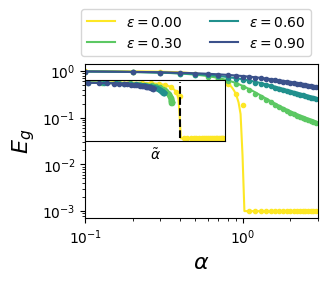

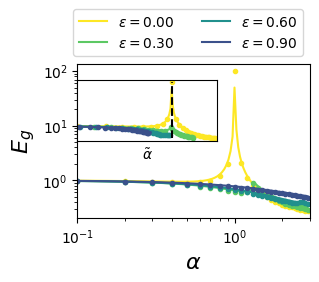

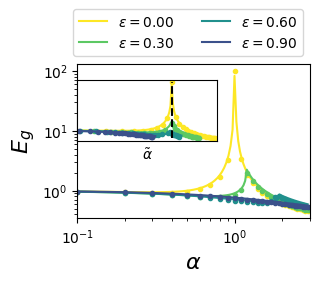

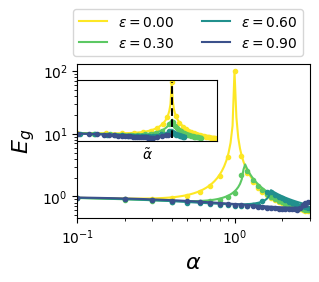

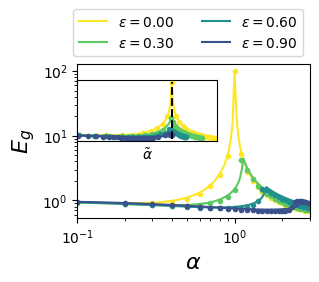

In [7]:
assert len(fn_list) > 0

noise_idx = -1
skip_idx = 1

eps_list = epsilon_list[::skip_idx]

for j, corr in enumerate(corr_list):

    fig, axs = plt.subplots(1, len(fn_list), figsize=(3*len(fn_list), 2))
    if len(fn_list) == 1:
        axs = [axs]
    
    ins_axs = [ax.inset_axes([0, 0.5, .6, .4]) for ax in axs]
    
    cmap_colors = [plt.cm.viridis_r(i) for i in np.linspace(0, 1, len(epsilon_list))]
    cmap_colors_alt = cmap_colors

    for n, fn in enumerate(fn_list):
        
        th_res = {key: all_results_th[key][j,noise_idx][::skip_idx] for key in ['C', 'Q', 'Chat', 'Qhat', 'Etr', 'alpha', 'alpha_eff', 'f', 'g']}
        th_res['Etr'] = th_res['Etr'] / (1+noise_list[noise_idx]**2*(1-corr))**2
        th_res = {key: np.clip(val, 1e-3, 1e2) for key, val in th_res.items()}
        alpha_th = th_res['alpha']
        alpha_eff_th = th_res['alpha_eff']
        
        exp_res = {key: all_results_exp[key][j,noise_idx][::skip_idx] for key in [f'gen_err_{fn}', f'tr_err_{fn}', f'eff_ratio_{fn}', f'eff_ratio2_{fn}']}
        exp_res['alpha_exp'] = np.tile(alpha_list, (len(eps_list),1))
        exp_res['alpha_eff_exp'] = exp_res['alpha_exp'] * erfc(eps_list[:,None] / np.sqrt(2*exp_res[f'gen_err_{fn}']))
        exp_res['eff_ratio'] = exp_res[f'eff_ratio_{fn}']
        exp_res['eff_ratio2'] = exp_res[f'eff_ratio2_{fn}']
        exp_res = {key: np.clip(val, 1e-3, 1e2) for key, val in exp_res.items()}
        
        gen_err_svr = exp_res[f'gen_err_{fn}']
        tr_err_svr = exp_res[f'tr_err_{fn}']
        alpha_exp = exp_res['alpha_exp']
        alpha_eff_exp = exp_res[f'alpha_eff_exp']
        alpha_eff_exp2 = alpha_exp*exp_res['eff_ratio']
        alpha_eff_exp3 = alpha_exp*exp_res['eff_ratio2']
        
        ylims = [np.min(th_res['C']), np.min([1.5, np.max(th_res['C'])])]
        ylims = [min(np.min(gen_err_svr), np.min(th_res['C'])), np.min([2.5, np.max(th_res['C'])])]
        ylims = [0, 2]
        
        for i, eps in enumerate(eps_list):
            
            if eps < .95:

                axs[n].loglog(alpha_th[i], (th_res['C'])[i], color=cmap_colors[i], label=rf'$\varepsilon={eps:.2f}$')
                axs[n].loglog(alpha_exp[i], gen_err_svr[i], '.', color=cmap_colors[i])
            
                ins_axs[n].loglog(alpha_eff_th[i], (th_res['C'])[i], color=cmap_colors[i], label=rf'$\varepsilon={eps:.2f}$')
                ins_axs[n].semilogy(alpha_eff_exp[i], gen_err_svr[i], '.', color=cmap_colors[i])
                
        
        ins_axs[n].vlines(1, np.min(gen_err_svr), np.max(gen_err_svr), color='k', linestyles='dashed')
        ins_axs[n].set_xlim([1e-1,3])
        ins_axs[n].set_xticks([])
        ins_axs[n].set_yticks([])
        ins_axs[n].minorticks_off()
        ins_axs[n].set_xlabel(r'$\tilde\alpha$')
        
        axs[n].set_ylabel(r'$E_{g}$', fontsize=font_axis_label)
        axs[n].set_xlabel(r'$\alpha$', fontsize=font_axis_label)
        axs[n].set_xlim([1e-1,3])
        axs[n].legend(ncols=2, bbox_to_anchor=(0.5, 0.9, 0.5, 0.5))

    # plt.savefig(f'./figures/gen_err_corr_{corr:.2f}.pdf', bbox_inches='tight')
    plt.show()

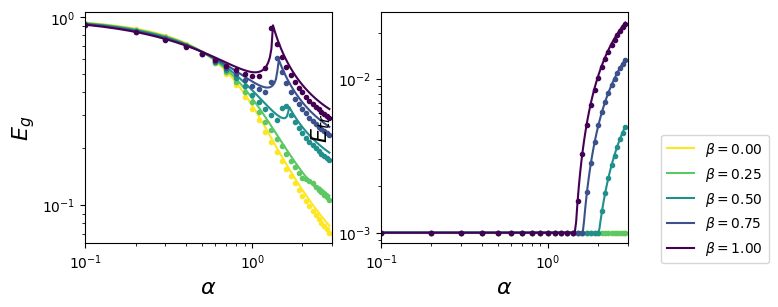

In [8]:
assert len(fn_list) > 0

eps_idx = 1
corr_idx = 1
fn_idx = 0
skip_idx = 1
noise_idx = 2

fig, axs = plt.subplots(1, 2, figsize=(7, 3))

cmap_colors = [plt.cm.viridis_r(i) for i in np.linspace(0, 1, len(epsilon_list))]
cmap_colors_alt = cmap_colors 

for corr_idx, noise in enumerate(corr_list):

    fn = fn_list[fn_idx]
    eps = eps_list[eps_idx]
    corr = corr_list[corr_idx]
    noise = noise_list[noise_idx]

    th_res = {key: all_results_th[key][corr_idx, noise_idx, eps_idx]
              for key in ['C', 'Q', 'Chat', 'Qhat', 'Etr', 'alpha', 'alpha_eff', 'f', 'g']}
    th_res['Etr'] = th_res['Etr'] / (1+noise**2*(1-corr))**2
    th_res = {key: np.clip(val, 1e-3, 1e2) for key, val in th_res.items()}
    alpha_th = th_res['alpha']
    alpha_eff_th = th_res['alpha_eff']

    exp_res = {key: all_results_exp[key][corr_idx, noise_idx, eps_idx]
               for key in [f'gen_err_{fn}', f'tr_err_{fn}', f'eff_ratio_{fn}', f'eff_ratio2_{fn}']}
    exp_res['alpha_exp'] = alpha_list
    exp_res['alpha_eff_exp'] = exp_res['alpha_exp'] * erfc(eps / np.sqrt(2*exp_res[f'gen_err_{fn}']))
    exp_res['eff_ratio'] = exp_res[f'eff_ratio_{fn}']
    exp_res['eff_ratio2'] = exp_res[f'eff_ratio2_{fn}']
    exp_res = {key: np.clip(val, 1e-3, 1e2) for key, val in exp_res.items()}

    gen_err_svr = exp_res[f'gen_err_{fn}']
    tr_err_svr = exp_res[f'tr_err_{fn}']
    alpha_exp = exp_res['alpha_exp']
    alpha_eff_exp = exp_res[f'alpha_eff_exp']
    alpha_eff_exp2 = alpha_exp*exp_res['eff_ratio']
    alpha_eff_exp3 = alpha_exp*exp_res['eff_ratio2']

    axs[0].loglog(alpha_th, (th_res['C']), color=cmap_colors[corr_idx], label=rf'$\beta={corr:.2f}$')
    axs[0].loglog(alpha_exp, gen_err_svr, '.', color=cmap_colors[corr_idx])
    
    axs[1].loglog(alpha_th, (th_res['Etr']), color=cmap_colors[corr_idx], label=rf'$\beta={corr:.2f}$')
    axs[1].loglog(alpha_exp, tr_err_svr, '.', color=cmap_colors[corr_idx])

    axs[0].set_ylabel(r'$E_{g}$', fontsize=font_axis_label)
    axs[0].set_xlabel(r'$\alpha$', fontsize=font_axis_label)
    axs[1].set_ylabel(r'$E_{tr}$', fontsize=font_axis_label)
    axs[1].set_xlabel(r'$\alpha$', fontsize=font_axis_label)
    axs[0].set_xlim([1e-1, 3])
    axs[1].set_xlim([1e-1, 3])
    axs[1].legend(bbox_to_anchor=(1.1, 0.0, 0.5, 0.5))

# plt.savefig(f'./figures/gen_err_corr_{corr:.2f}.pdf', bbox_inches='tight')
plt.show()